# Machine Learning for Medicine TP 7
## Bayesian Networks for Clinical Data Analysis

In [1]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
import os
import pandas as pd

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.bn2graph as bnPlot
import pyAgrum.lib.dynamicBN as gdyn


## 1 - Creating a network using PyAgrum
### creating graph

In [2]:
bn = gum.BayesNet('type 2 diabetes remission')
print(bn)

BN{nodes: 0, arcs: 0, domainSize: 1, dim: 0}


In [3]:
g,i,o,r = [bn.add(name, 2) for name in "gior" ]
print(bn)


BN{nodes: 4, arcs: 0, domainSize: 16, dim: 8}


In [4]:
for link in [(g,i), (g,o), (o,r), (i,r)]:
    bn.addArc(*link)
print(bn)

BN{nodes: 4, arcs: 4, domainSize: 16, dim: 18}


In [5]:
bn

(gum::BayesNet<double>@0x564400f07190) BN{nodes: 4, arcs: 4, domainSize: 16, dim: 18}

In [6]:
bn.cpt(g)[:] = .5

bn.cpt(i)[{'g': 0}] = [.9, .1]
bn.cpt(i)[{'g': 1}] = [.1, .9]


bn.cpt(o)[{'g': 0}] = [.7, .3]
bn.cpt(o)[{'g': 1}] = [.25, .75]

bn.cpt(r)[{'o': 0, 'i': 0}] = [.1, .9]
bn.cpt(r)[{'o': 0, 'i': 1}] = [.7, .3]
bn.cpt(r)[{'o': 1, 'i': 0}] = [.4, .6]
bn.cpt(r)[{'o': 1, 'i': 1}] = [.9, .1]


In [7]:
bn.cpt('r')

(gum::Potential<double>@0x564400463260) <r:0|o:0|i:0> :: 0.1 /<r:1|o:0|i:0> :: 0.9 /<r:0|o:1|i:0> :: 0.4 /<r:1|o:1|i:0> :: 0.6 /<r:0|o:0|i:1> :: 0.7 /<r:1|o:0|i:1> :: 0.3 /<r:0|o:1|i:1> :: 0.9 /<r:1|o:1|i:1> :: 0.1

### inference

In [8]:
ie = gum.LazyPropagation(bn)


In [9]:
ie.makeInference()

In [10]:
ie.posterior(r)

(gum::Potential<double>@0x564400557ae0) <r:0> :: 0.52225 /<r:1> :: 0.47775

In [11]:
ie.posterior(o)

(gum::Potential<double>@0x564400528820) <o:0> :: 0.475 /<o:1> :: 0.525

In [12]:
ie.posterior(i)

(gum::Potential<double>@0x56440068d2a0) <i:0> :: 0.5 /<i:1> :: 0.5

probability to get the remission if the
glycemia level is less than 6.5 and no drugs are taken :

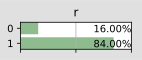

In [13]:
gnb.showPosterior(bn,{'g':0, 'o':0}, 'r')

probability to get the remission if the glycemia level is bigger than 6.5 and
insulin is prescribed:

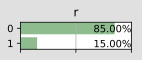

In [14]:
gnb.showPosterior(bn,{'g':1, 'i':1}, 'r')

## 2 - Construct Bayesian networks from real data

In [15]:
ds_env   = pd.read_csv('data/SPLEX_env.txt',   sep=' ')
ds_host  = pd.read_csv('data/SPLEX_host.txt',  sep=' ')
ds_micro = pd.read_csv('data/SPLEX_micro.txt', sep=' ')

columns_env   = list(ds_env  .columns)
columns_host  = list(ds_host .columns)
columns_micro = list(ds_micro.columns)


In [16]:
data = ds_env.join(ds_host).join(ds_micro)
len(data.columns), len(columns_env), len(columns_host), len(columns_micro)


(118, 63, 45, 10)

In [17]:
l=[]
for col in data.columns.values:
    bins = np.linspace(min(data[col]), max(data[col]), 5)
    l.append(pd.DataFrame(np.digitize(data[col], bins),columns=[col]))
    
discr_data = pd.concat(l, join='outer', axis=1)
discr_data.to_csv("data/discr_data.csv",index=False)


In [58]:
data_parts = [
    ('env', columns_env),
    ('host', columns_host),
#     ('micro', columns_micro),
    ('env+host', columns_env+columns_host),
]
learner_list = [
    ('LocalSearch', lambda l:l.useLocalSearchWithTabuList()),
    ('Gready', lambda l:l.useGreedyHillClimbing()),
]

for data_name, data_columns in data_parts:
    discr_data_path = "data/discr_data_"+data_name+".csv"
    discr_data[data_columns].to_csv(discr_data_path,index=False)
    for learner_name, learner_fun in learner_list:
        learner = gum.BNLearner(discr_data_path)
        learner.useLocalSearchWithTabuList()
        bn = learner.learnBN()
        graph_path = 'data/network_'+data_name+'_'+learner_name
        bnPlot.dotize(bn, graph_path, format='pdf')
        print("{}\n-> saved at '{}.pdf'".format(bn, graph_path))


BN{nodes: 63, arcs: 12, domainSize: 10^43.1935, dim: 773}
-> saved at 'data/network_env_LocalSearch.pdf'
BN{nodes: 63, arcs: 12, domainSize: 10^43.1935, dim: 773}
-> saved at 'data/network_env_Gready.pdf'
BN{nodes: 45, arcs: 27, domainSize: 10^30.5712, dim: 1613}
-> saved at 'data/network_host_LocalSearch.pdf'
BN{nodes: 45, arcs: 27, domainSize: 10^30.5712, dim: 1613}
-> saved at 'data/network_host_Gready.pdf'
BN{nodes: 108, arcs: 44, domainSize: 10^73.7646, dim: 2257}
-> saved at 'data/network_env+host_LocalSearch.pdf'
BN{nodes: 108, arcs: 44, domainSize: 10^73.7646, dim: 2257}
-> saved at 'data/network_env+host_Gready.pdf'


## 3 - Dynamic Bayesian networks

In [30]:
ds_dynamic = pd.read_csv('data/dynamic.txt', sep=' ')
ds_dynamic

HbA1C0  HbA1C1  HbA1C2    Gly0  Gly1  Gly2  Poids0  Poids1  Poids2  \
0       6.7     5.9     6.1   6.105   4.7   5.0   110.7    67.0    72.0   
1       6.0     5.2     5.2   6.327   4.0   4.9   177.0   127.0   143.6   
2       6.8     5.9     6.6   7.881   6.0   6.4   133.4   110.0   115.0   
3       9.4     7.7     8.4  11.700   9.1   7.9    95.2    80.0    85.1   
4       8.0     5.7     5.9  10.700   5.4   5.6   120.0    92.1    84.7   
..      ...     ...     ...     ...   ...   ...     ...     ...     ...   
170     6.8     5.3     6.1   5.300   6.0   5.3   105.6    73.3    75.0   
171     7.6     5.5     7.9   4.500   4.7  10.6   146.7    96.4    88.8   
172     6.3     6.1     5.9   5.600   5.4   5.0   102.0    81.4    89.6   
173     5.9     6.3     6.3   5.500   5.4   7.7    90.5    73.0    78.0   
174     6.8     7.7     5.3   6.100   8.8   4.4   141.4    96.1    86.0   

     Status0  Status1  Status2  
0          1        1        3  
1          1        1        1  
2          1        3        2  
3          1        2        2  
4          1        1        3  
..       ...      ...      ...  
170        1        2        3  
171        1        2        2  
172        1        3        1  
173        1        2        2  
174        1        2        1  

[175 rows x 12 columns]

In [74]:
l=[]
for col in ds_dynamic.columns.values:
    bins = np.linspace(min(ds_dynamic[col]), max(ds_dynamic[col]), 5)
    l.append(pd.DataFrame(np.digitize(ds_dynamic[col], bins),columns=[col]))
    
discr_dyna_path = "data/discr_dynamic.csv"
discr_dynamic = pd.concat(l, join='outer', axis=1)
discr_dynamic.to_csv(discr_dyna_path,index=False)


In [75]:
learner = gum.BNLearner(discr_dyna_path)
learner.useLocalSearchWithTabuList()
bn_dynamic = learner.learnBN()
bn_dynamic


(gum::BayesNet<double>@0x5644022c09c0) BN{nodes: 12, arcs: 10, domainSize: 10^7.14806, dim: 199}

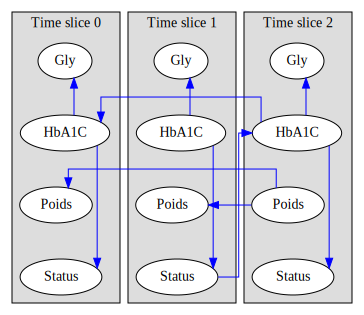

In [76]:
gdyn.showTimeSlices(bn_dynamic)#, format="png")